In [1]:
import sys
#Change path specificly to your directories
sys.path.insert(1, '/home/codahead/Fishial/FishialReaserch')

import torch
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import requests
import json
import numpy as np

from module.classification_package.src.dataset import FishialDataset
from module.classification_package.src.loss_functions import TripletLoss, QuadrupletLoss
from module.classification_package.src.model import EmbeddingModel, Backbone, Model

import time
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import os
import cv2

import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np

from torch import nn
from torch.optim import Optimizer, SGD
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from sklearn.neighbors import KDTree
from PIL import Image
import numpy as np
import random
import sklearn.metrics.pairwise
import scipy.spatial.distance
from sklearn.metrics import confusion_matrix
import copy
import json
import time
import requests
from sklearn.metrics import classification_report
import logging
import torch
import json
import sys
import numbers

import numpy as np
from torchvision.transforms.functional import pad
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
np.set_printoptions(precision=20)
torch.set_printoptions(precision=20)

In [219]:
def reverse_norm_image(image):
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    reverse_image = image * STD[:, None, None] + MEAN[:, None, None]
    return reverse_image.permute(1, 2, 0).cpu().numpy()

def init_model(ckp=None):
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc = nn.Identity()

    backbone = Backbone(resnet18)
    model = EmbeddingModel(backbone)
    if ckp:
        model.load_state_dict(torch.load(ckp))
    model.eval()
    return model


def remove_dupliceta(mylist):
    seen = set()
    newlist = []
    for item in mylist:
        t = tuple(item)
        if t not in seen:
            newlist.append(item)
            seen.add(t)
    return newlist

def read_json(data):
    with open(data) as f:
        return json.load(f)

def classify(data, embedding):    
    сlassification_lib = []

    for k in data:
        for kk in data[k]['vectors']:
            distance = np.abs(embedding - np.array(kk)).sum()
            сlassification_lib.append([k, distance])
    сlassification_lib = sorted(сlassification_lib, key=lambda x: x[1], reverse=False)
    return сlassification_lib

def get_mask(image, pts):
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x, y, w, h = rect
    croped = image[y:y + h, x:x + w].copy()

    ## (2) make mask
    pts = pts - pts.min(axis=0)

    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    return dst

def get_data_base_of_embed(path):
    data = read_json(path)
    for i in data:
        for z in range(len(data[i]["vectors"])):
            data[i]["vectors"][z] = [float(val) for val in data[i]["vectors"][z]]
    return data

def get_data_base(model, data_set):
    data_with_vectors = copy.deepcopy(data_set.library_name)
    for i in range(len(data_set)):
        print("Left: {}".format(len(data_set) - i), end="\r")
        output = model(data_set[i][0].unsqueeze(0)).detach().numpy()
        converted_list = output[0]
        if "vectors" in data_with_vectors[int(data_set[i][1])]:
            data_with_vectors[int(data_set[i][1])]["vectors"].append(converted_list)
        else:
            data_with_vectors[int(data_set[i][1])].update({"vectors": [converted_list]})
        start_time = time.time()
    return data_with_vectors

def eval_data_set(model, data_main, data_eval):
    y_true = []
    y_pred = []

    for class_id in range(len(data_eval)):
        for vector in data_eval[class_id]['vectors']:
            topest = classify(data_train, np.array(vector))
            flatten = [iii[0] for iii in topest[:10]]
            my_dict = [[i, flatten.count(i)] for i in flatten]
            my_dict = remove_dupliceta(my_dict)
            my_dict = sorted(my_dict, key=lambda x: x[1], reverse=True)
            y_true.append(class_id)
            y_pred.append(topest[0][0])
    return y_true, y_pred

In [220]:
loader = transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
data_set_train = FishialDataset(
        json_path="../dataset/data_train.json",
        root_folder="../dataset",
        transform=loader
    )

data_set_val = FishialDataset(
        json_path="../dataset/data_test.json",
        root_folder="../dataset",
        transform=loader
    )

In [221]:
model = init_model('output/ckpt_triplet_cross_entropy_0.86_28600.0.ckpt')

In [222]:
data_train = get_data_base(model, data_set_train)
data_eval = get_data_base(model, data_set_val)

In [228]:
# y_true, y_pred = eval_data_set(model, data_train, data_eval)
cohen_kappa_score(y_true, y_pred)

0.7991132058388579

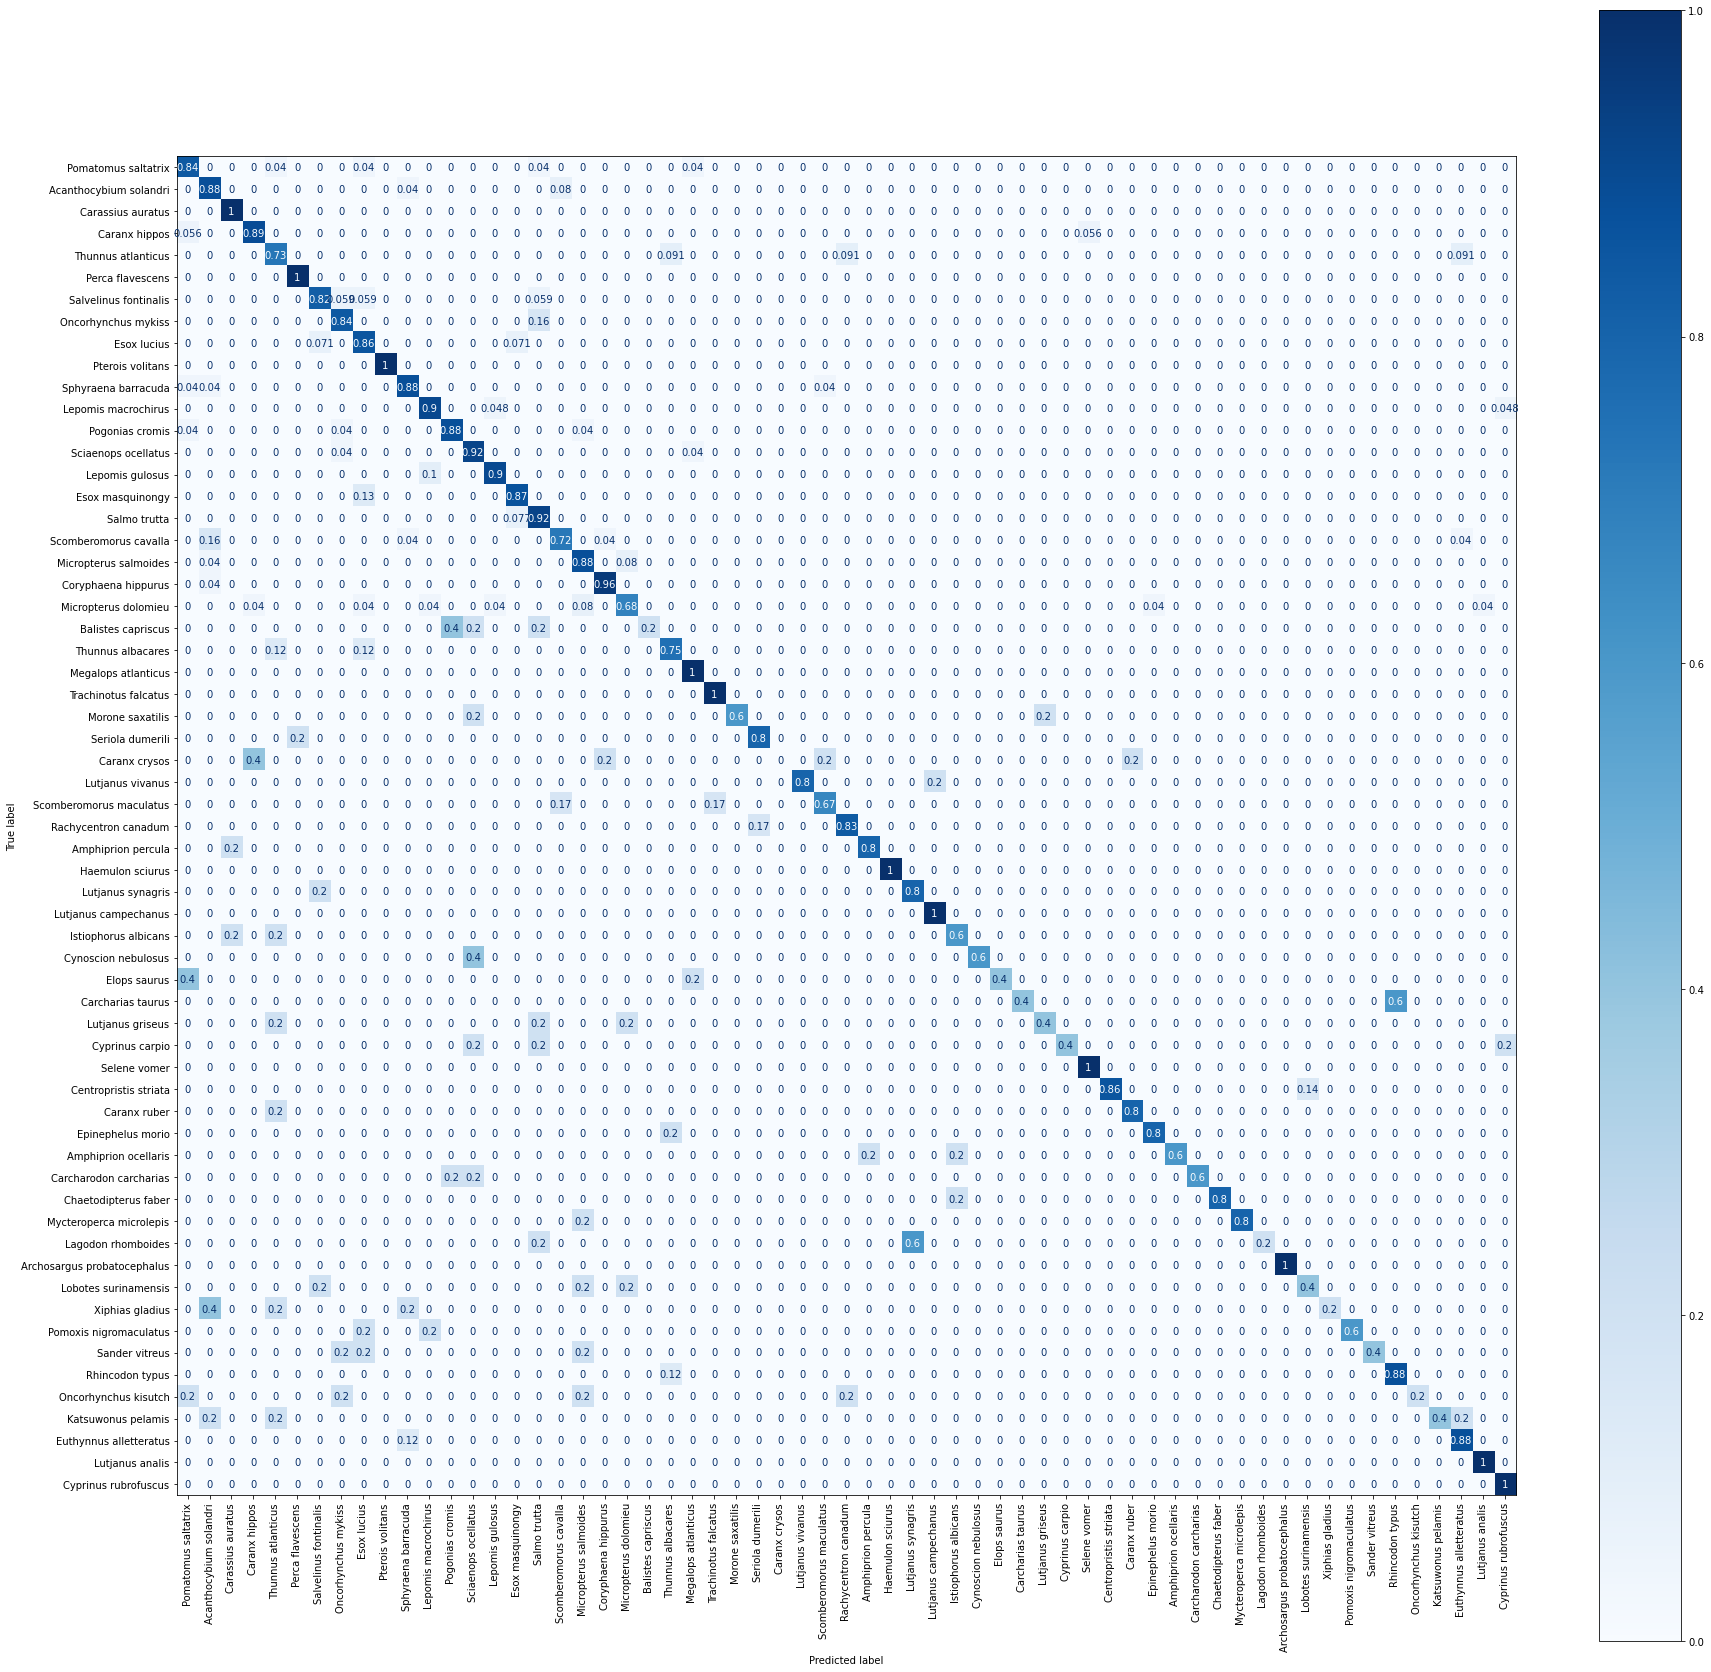

In [224]:
labels = [data_set_train.library_name[i]['label'] for i in data_set_train.library_name]
cm = confusion_matrix(y_true, y_pred, normalize='true')
fig, ax = plt.subplots(figsize=(30, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=90)
plt.show()

In [225]:
print(classification_report(y_true, y_pred, target_names=labels))

                             precision    recall  f1-score   support

        Pomatomus saltatrix       0.78      0.84      0.81        25
     Acanthocybium solandri       0.69      0.88      0.77        25
          Carassius auratus       0.88      1.00      0.94        15
              Caranx hippos       0.84      0.89      0.86        18
         Thunnus atlanticus       0.53      0.73      0.62        11
           Perca flavescens       0.93      1.00      0.97        14
      Salvelinus fontinalis       0.82      0.82      0.82        17
        Oncorhynchus mykiss       0.81      0.84      0.82        25
                Esox lucius       0.57      0.86      0.69        14
           Pterois volitans       1.00      1.00      1.00        12
        Sphyraena barracuda       0.85      0.88      0.86        25
        Lepomis macrochirus       0.86      0.90      0.88        21
            Pogonias cromis       0.88      0.88      0.88        25
        Sciaenops ocellatus      

/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [102]:
def _get_scores(report):
    labels_row = []
    scores = []
    for i in report:
        labels_row.append(i)
        row = []
        if type(report[i]) != dict:
            continue
        for z in report[i]:
            row.append(report[i][z])
        scores.append(row)
    scores = np.array(scores[:61])
    
    return labels_row, scores

In [211]:
list_od_models = ['ckpt_triplet_cross_entropy_0.875_48400.0.ckpt', 
                  'ckpt_triplet_cross_entropy_0.87_42000.0.ckpt',
                 'ckpt_triplet_cross_entropy_0.84_5800.0.ckpt']
labels = [data_set_val.library_name[label]['label'] for label in data_set_val.library_name]
root_folder = 'output'
data_full = {}
scores = []
for model_path in list_od_models:
    model = init_model(os.path.join(root_folder, model_path))
    data_train = get_data_base(model, data_set_train)
    data_eval = get_data_base(model, data_set_val)
    y_true, y_pred = eval_data_set(model, data_train, data_eval)
    dictd = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    
#     _, scores_tmp = _get_scores(dictd)
#     if len(scores) == 0:
#         scores = scores_tmp
#     else:
#         scores = np.concatenate((scores, scores_tmp), axis=1)
        
# full_data = {}
# for model_score in range(int(len(scores[0])/4)):
#     for idxx, name in enumerate(['Pre', 'TPR', 'F1']):
#         name_metrics = "{}_{}".format(name, model_score)
#         full_data.update({name_metrics: [round(iix, 2) for iix in scores[:, model_score * 4 + idxx]]})

/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [215]:
df

,Pre_0,TPR_0,F1_0,Pre_1,TPR_1,F1_1,Pre_2,TPR_2,F1_2
Pomatomus saltatrix,0.79,0.88,0.83,0.00,0.00,0.00,0.09,0.00,0.05
Acanthocybium solandri,0.82,0.92,0.87,0.00,0.00,0.00,-0.13,-0.12,-0.13
Carassius auratus,0.88,1.00,0.94,0.00,0.00,0.00,-0.17,0.00,-0.11
Caranx hippos,0.82,1.00,0.90,0.00,0.00,0.00,-0.04,0.00,-0.02
Thunnus atlanticus,0.69,0.82,0.75,-0.09,0.00,-0.06,-0.16,-0.09,-0.13
Perca flavescens,0.78,1.00,0.88,-0.04,0.00,-0.03,0.10,0.00,0.05
Salvelinus fontinalis,0.88,0.82,0.85,-0.06,0.00,-0.03,0.05,-0.06,-0.01
Oncorhynchus mykiss,0.74,1.00,0.85,0.09,-0.04,0.04,0.03,-0.08,-0.01
Esox lucius,0.63,0.86,0.73,-0.03,0.00,-0.02,0.08,0.00,0.04
Pterois volitans,1.00,1.00,1.00,-0.08,0.00,-0.04,-0.15,-0.08,-0.12


In [216]:

labels = [data_set_val.library_name[label]['label'] for label in data_set_val.library_name]
model = init_model('output/ckpt_triplet_cross_entropy_0.875_48400.0.ckpt')
data_train = get_data_base(model, data_set_train)
data_eval = get_data_base(model, data_set_val)
y_true, y_pred = eval_data_set(model, data_train, data_eval)
dictd = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/codahead/anaconda3/envs/d2go-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [217]:
with open('output/triplet_best.json', 'w', encoding='utf-8') as f:
        json.dump(dictd, f)